24


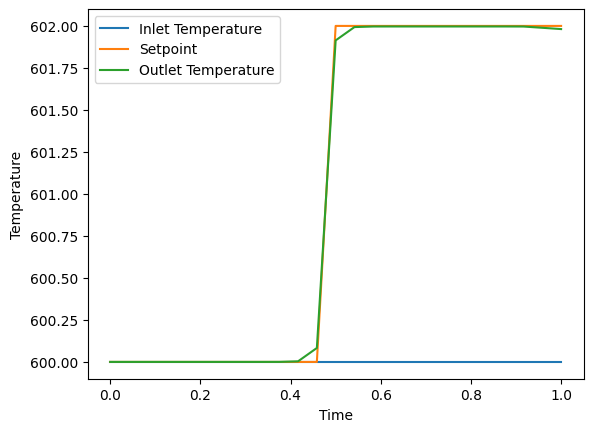

In [1]:
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Heater
from idaes.models.properties.general_helmholtz import (
    HelmholtzParameterBlock,
    PhaseType,
    StateVars,
)
from idaes.core.util.model_statistics import degrees_of_freedom
from matplotlib import pyplot as plt
from pyomo.dae import Integral

m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=True,time_units=pyo.units.s,time_set=[0,1])
m.fs.properties = HelmholtzParameterBlock(
    pure_component="h2o",
    phase_presentation=PhaseType.MIX,
    state_vars=StateVars.TPX,
)
m.fs.heater = Heater(property_package=m.fs.properties,dynamic=True,has_holdup=True,)


m.fs.setpoint = pyo.Var(m.fs.time)
@m.fs.Constraint(m.fs.time)
def setpoint_eq(fs, t):
    if t < 0.5:
        return (
            fs.setpoint[t] == 600
        )
    else:
        return (
            fs.setpoint[t] == 602
        )



# Optimisation function: gets to setpoint as fast as possible
# minimise the integral of error of m.fs.tank.control_volume.properties_out[12].pressure
# where the error is the difference between the current value and the setpoint (3e5), m.fs.ctrl.setpoint
# and the integral is the sum of the error over the time horizon

m.fs.error = pyo.Var(m.fs.time)
#m.delta_error = pyodae.DerivativeVar(m.error, withrespectto=m.fs.time)
@m.fs.Constraint(m.fs.time)
def error_expr(fs, t):
   return fs.error[t] == (fs.setpoint[t] - fs.heater.outlet.temperature[t])**2 + (fs.heater.heat_duty[t]/90000)**2
# set starting error value to 0
m.fs.error[0].fix(0)
# Calculate the integral of the error

def _intE(fs,t):
    return fs.error[t]
m.fs.intE = Integral(m.fs.time, wrt=m.fs.time, rule=_intE)
m.fs.objective = pyo.Objective(rule=m.fs.intE, sense=pyo.minimize) # minimise the total error



pyo.TransformationFactory("dae.finite_difference").apply_to(
    m.fs, 
    nfe=24, # Number of finite elements to use for discretization 
    wrt=m.fs.time, 
    scheme="BACKWARD"
)

# If we're fixing all the variables, we have to do it after the transformation

m.fs.heater.inlet.flow_mol.fix(100)
m.fs.heater.inlet.temperature.fix(600)
m.fs.heater.inlet.vapor_frac.fix(1)
m.fs.heater.inlet.pressure.fix(101325)
#m.fs.heater.heat_duty.fix(10_000)
m.fs.heater.control_volume.volume.fix(1)

# Fix the derivative variables to zero at time 0 (steady state assumption)
m.fs.fix_initial_conditions()
# or, specify holdup
#m.fs.heater.control_volume.material_holdup[0, 'Mix', 'h2o'].fix(0.001)
#m.fs.heater.control_volume.energy_holdup[0, :].fix(0)
# or, specify accumulation (fix_initial_conditions sets the accumulation to 0)
#m.fs.heater.control_volume.material_accumulation[:, :].fix(300)
#m.fs.heater.control_volume.energy_accumulation[:, :].fix(300)

print(degrees_of_freedom(m))
solver = pyo.SolverFactory("ipopt")
solver.solve(m)

time = list(m.fs.time)
T_in = [pyo.value(m.fs.heater.inlet.temperature[t]) for t in time]
T_out = [pyo.value(m.fs.heater.outlet.temperature[t]) for t in time]
setpoints = [pyo.value(m.fs.setpoint[t]) for t in time]
work = [pyo.value(m.fs.heater.heat_duty[t]) for t in time]
error = [pyo.value(m.fs.error[t]) for t in time]

plt.plot(time, T_in, label="Inlet Temperature")
plt.plot(time, setpoints, label="Setpoint")
plt.plot(time, T_out, label="Outlet Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()

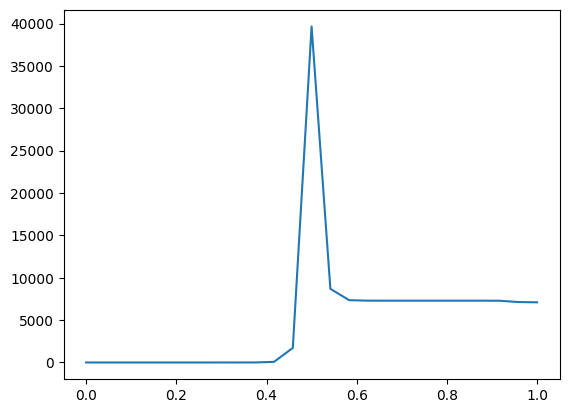

In [2]:
plt.plot(time, work, label="Work")

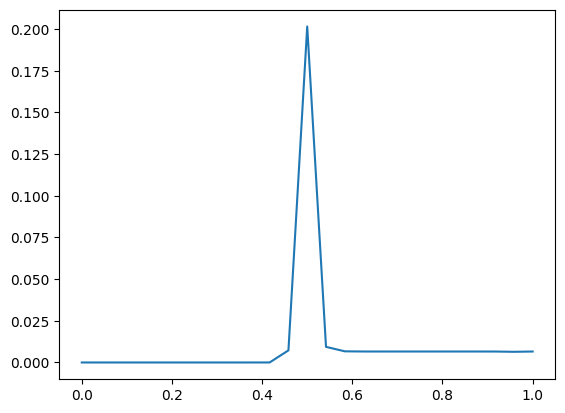

In [3]:
plt.plot(time, error, label="Error")